In [143]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import numpy as np
import math
import glob
import os

%matplotlib inline

<b>##Task1:Provide an example of a distortion-corrected .</b>

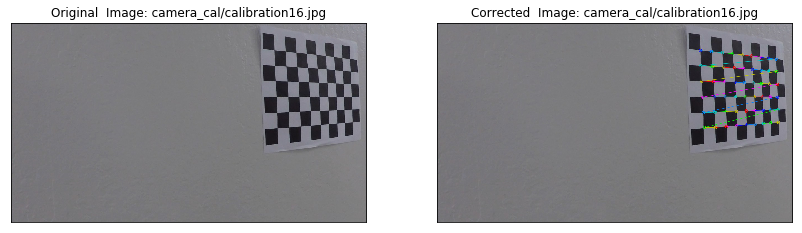

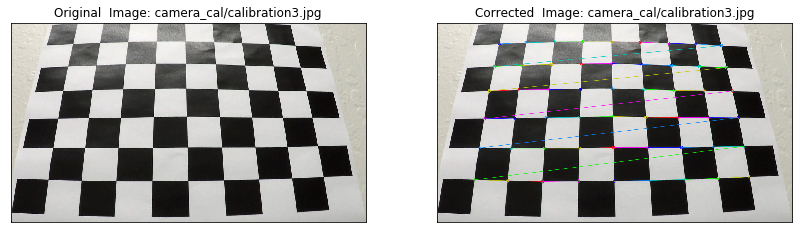

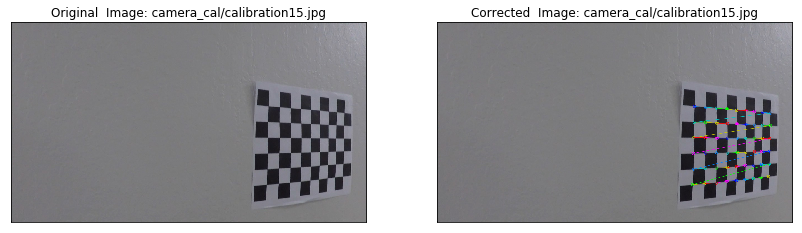

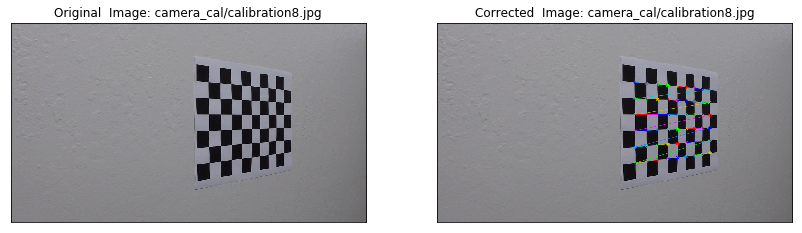

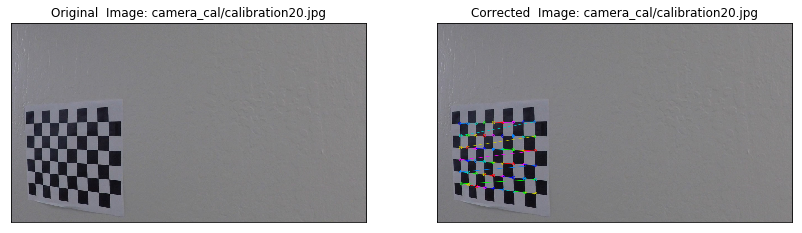

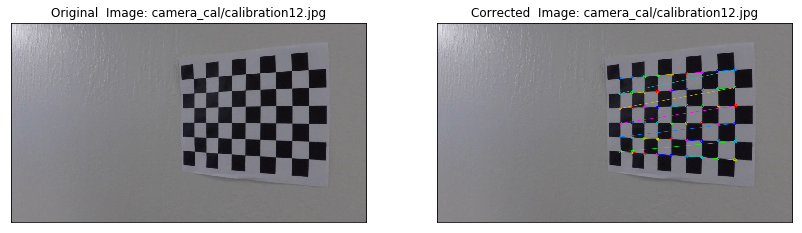

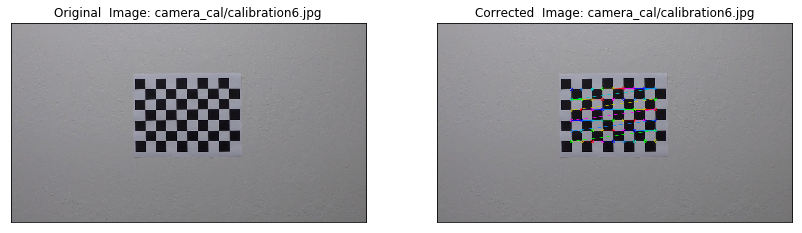

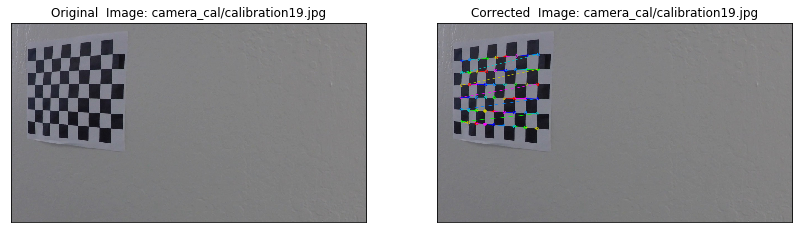

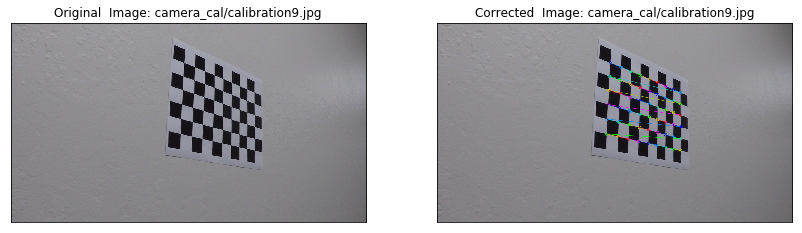

Not able to detect for file camera_cal/calibration1.jpg


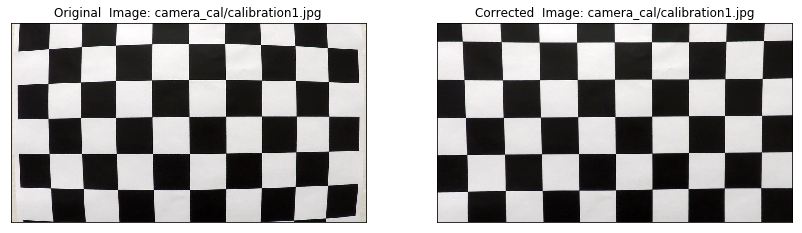

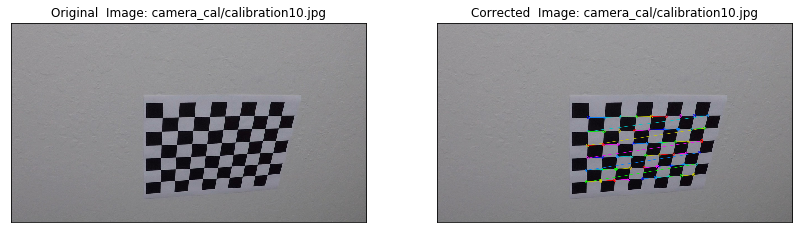

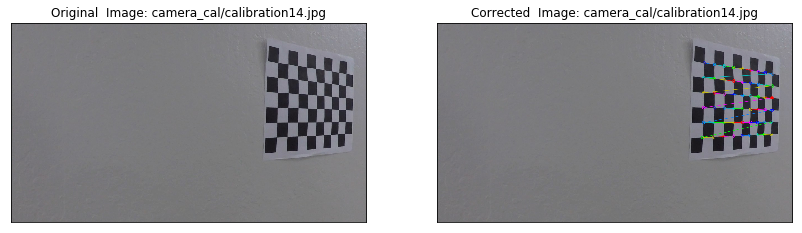

Not able to detect for file camera_cal/calibration4.jpg


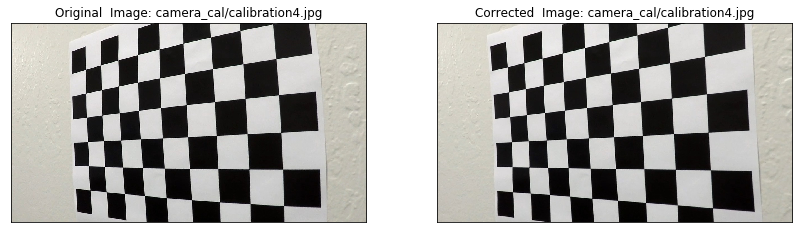

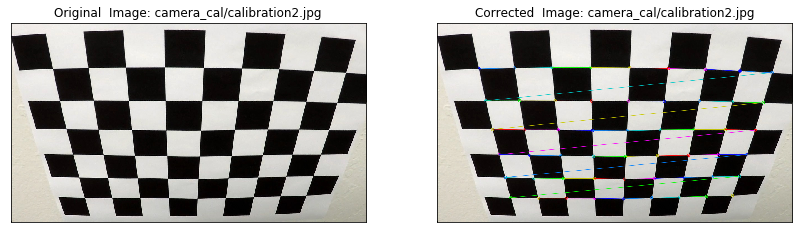

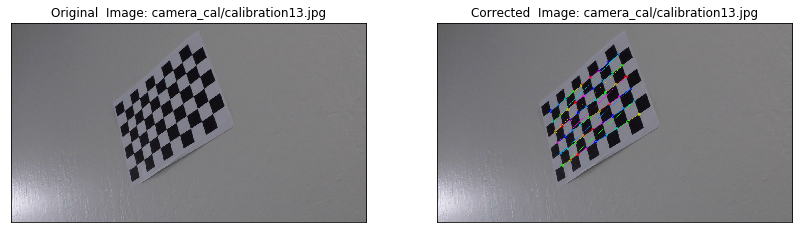

Not able to detect for file camera_cal/calibration5.jpg


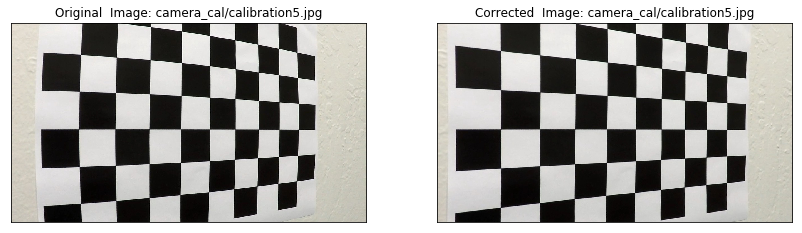

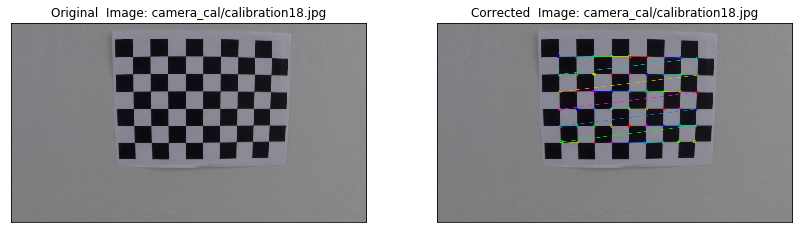

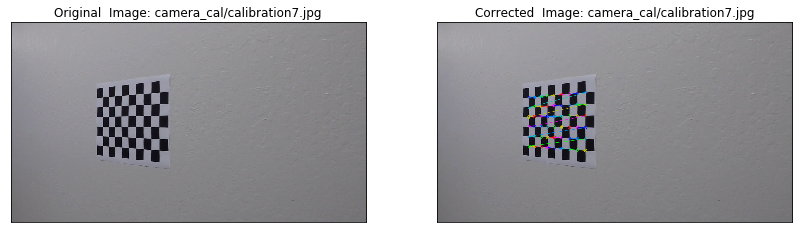

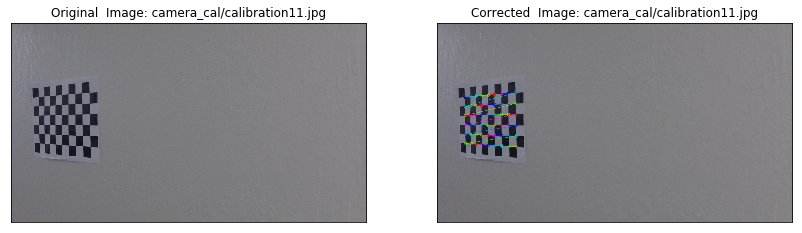

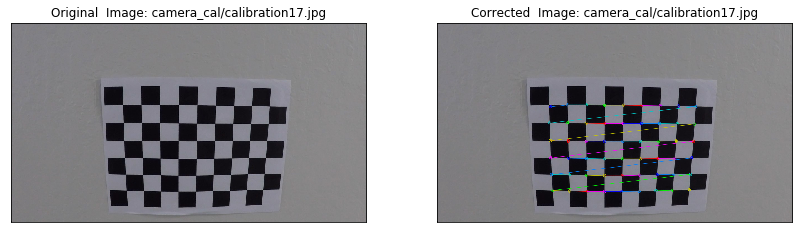

In [126]:
#IFirst we will mention two arrays objponts and imgpoint.Objpoints represent the 3D points which is present
#on real object and imgpoints will be our 2D flat representation of these points
objpoints = []
imgpoints = []

#While going through task its observed that we have 9*4 9*5 9*6 8*6 7*6 5*6 dimension images.In Ruberik its mentioned for 9*6 so we will discard imgpoints and objpoints for those
x = 9
y = 6

objp = np.zeros((x*y,3),np.float32)
objp[:,:2] = np.mgrid[0:x,0:y].T.reshape(-1,2)


image_names = glob.glob("camera_cal/calibration*.jpg")

for image in image_names:
    img = mpimg.imread(image)
    plt.figure(figsize=(14,12))
    plt.subplot(121)
    plt.title("Original  Image: "+ image)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    img_copy = np.copy(img)
    img_size = (img.shape[1], img.shape[0])
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (x,y), None)
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)
        cv2.drawChessboardCorners(img_copy,(corners.shape[1],corners.shape[0]), corners, ret)
    else:
        print("Not able to detect for file",image)

#Now as we have ObjectPoints and Image Points available lets use calibrateCamera to calibrate camera and then undistort method from cv2 package to undistort distorted image


        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
        img_copy = cv2.undistort(img_copy, mtx, dist, None, mtx)

    plt.subplot(122)
    plt.title("Corrected  Image: "+ image)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img_copy)
    
    plt.show()
  



<b>Task2:- Binary Threshold</b>


In [127]:
#Sobel Operator can be used for more efficient derivation
#We will be using gradient threshold on x,directional threshold and color threshold
# R & G thresholds helps to detect yellow lanes well.
# S channel performs well for detecting bright yellow and white lanes
#We will create helper method independently for these and then combine all the threshold to get a optimized result

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def undistort_frame(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

def combined_threshold(img):
    
    img = cv2.undistort(img, mtx, dist, None, mtx)

    gray = grayscale(img)
    
    height, width = gray.shape
    
    sx_binary = abs_sobel_thresh(gray, 'x', 10, 200)
    
    dir_binary = dir_threshold(gray, thresh=(np.pi/6, np.pi/2))
    
    combined_condition = ((sx_binary == 1) & (dir_binary == 1))
    
    color_threshold = 150
    R = img[:,:,0]
    G = img[:,:,1]
    color_combined = np.zeros_like(R)
    r_g_condition = (R > color_threshold) & (G > color_threshold)
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]
    
    s_thresh = (100, 255)
    s_condition = (S > s_thresh[0]) & (S <= s_thresh[1])
    
    l_thresh = (120, 255)
    l_condition = (L > l_thresh[0]) & (L <= l_thresh[1])

    color_combined[(r_g_condition & l_condition) & (s_condition | combined_condition)] = 1
    
    mask = np.zeros_like(color_combined)
    region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    thresholded = cv2.bitwise_and(color_combined, mask)
    
    return thresholded
    
    
    
def abs_sobel_thresh(gray, orient='x', thresh_min=0, thresh_max=255):
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    max_value = np.max(abs_sobel)
    binary_output = np.uint8(255*abs_sobel/max_value)
    threshold_mask = np.zeros_like(binary_output)
    threshold_mask[(binary_output >= thresh_min) & (binary_output <= thresh_max)] = 1
    return threshold_mask

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    direction = np.arctan2(abs_sobel_y,abs_sobel_x)
    direction = np.absolute(direction)
    mask = np.zeros_like(direction)
    mask[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return mask



 <b>Example of a binary image result</b>

Text(0.5,1,'Thresholded Image')

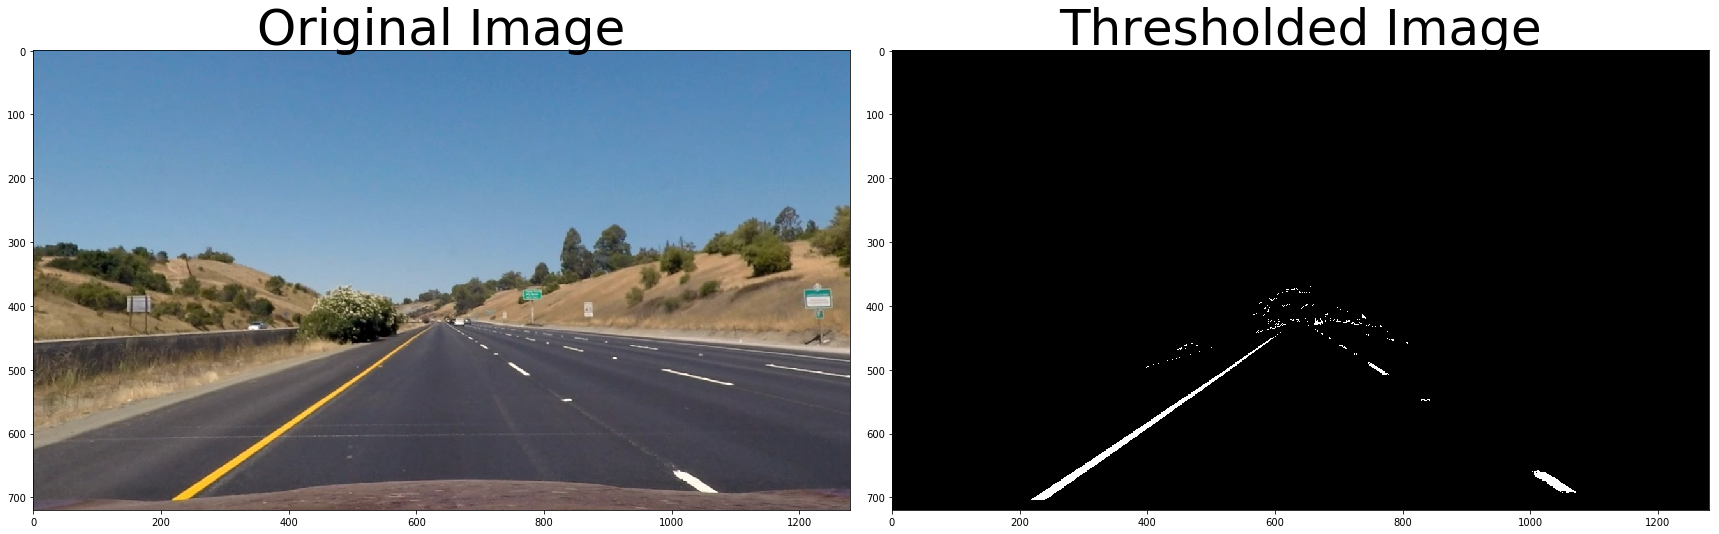

In [128]:
example_img = mpimg.imread('test_images/straight_lines1.jpg')
thresholded_image = combined_threshold(example_img)
example_img = cv2.undistort(example_img,mtx,dist,None,mtx)
cv2.imwrite("thresholded_image.jpg",thresholded_image)

#Visualization
f, (ax1,ax2) = plt.subplots(1,2,figsize=(24,9))
f.tight_layout()
ax1.imshow(example_img)
ax1.set_title('Original Image',fontsize=50)
ax2.imshow(thresholded_image,cmap='gray')
ax2.set_title('Thresholded Image',fontsize=50)


In [129]:
#Perspective transform:By this we are trying to acheive Bird Eye View of the lane line.We will select 4 point as src and transform the perspective to 4 dest point 

def perspective_transform(img):
    src = np.float32([[568, 468.5], [715, 468.5], [1041.5, 679.1], [269.5, 679.1]])
    dest = np.float32([[400, 0], [880, 0], [880, 710], [400, 710]])
    M = cv2.getPerspectiveTransform(src, dest)
    
    Minv = cv2.getPerspectiveTransform(dest, src)
    
    warped_img = cv2.warpPerspective(img, M, (1280, 720), flags=cv2.INTER_LINEAR)
  
    return warped_img, M, Minv

#Example of perspective Transform

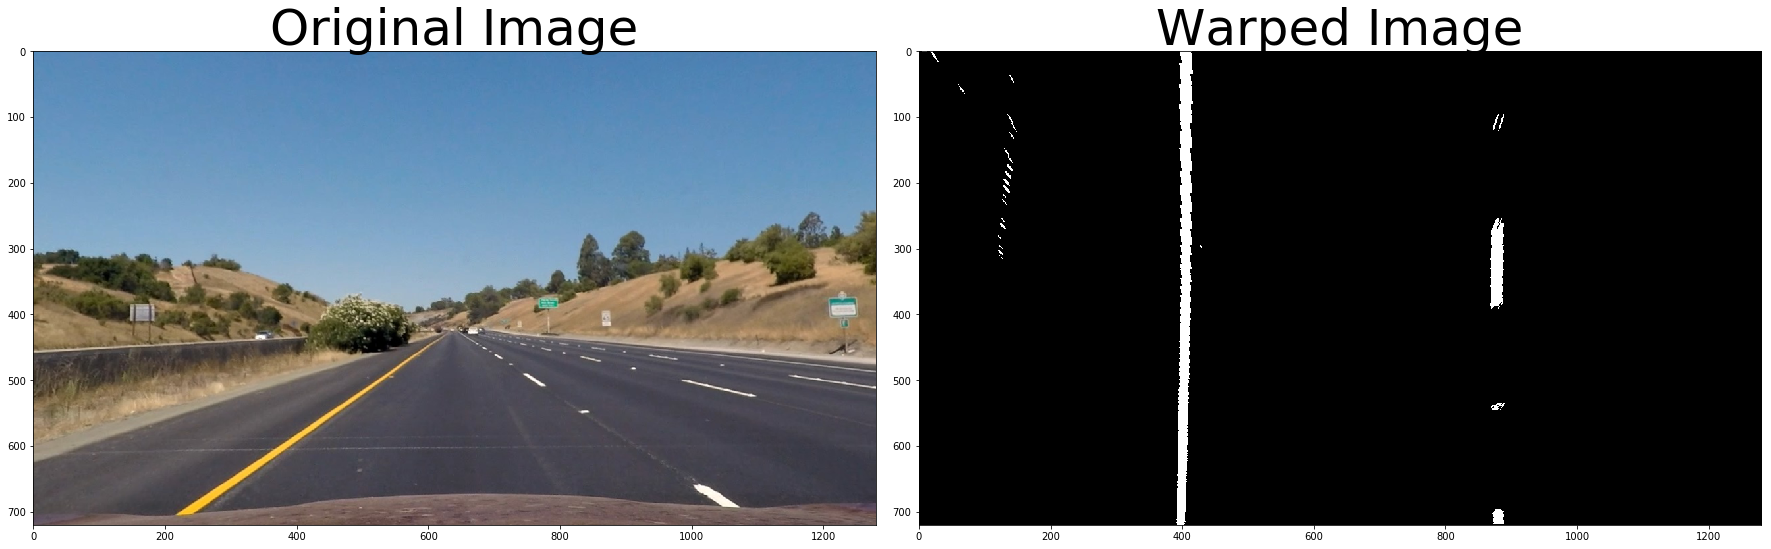

In [130]:
warped_img, M, Minv = perspective_transform(thresholded_image)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(example_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped_img, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [131]:
#Now we have the perspective transformed Image next we will use Hitogram and plot in it.The two peak intensity that we will get will point
#to 2 base points and then we can use sliding window algorithm to trace line


def find_lane_pixels(binary_warped):
    
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:, :], axis=0)
    
    mid = np.int(len(histogram)//2)
    left_window_mid = np.argmax(histogram[0:mid])
    right_window_mid = np.argmax(histogram[mid:]) + mid
    
    nwindows = 9
    window_height = np.int(binary_warped.shape[0]/nwindows)
    margin = 100
    nonzero = binary_warped.nonzero()
    
    min_nonzero_pixel = 200
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_fit= []
    right_lane_fit = []
    height = binary_warped.shape[0]
    left_windows = []
    right_windows = []
    for i in range(nwindows):
        # Create two rectangular windows, calculate from the image center and margin and store them
        win_top = height - (i + 1) * window_height
        win_bottom = win_top + window_height
        left_win_left = left_window_mid - margin
        left_win_right = left_window_mid + margin
        right_win_left = right_window_mid - margin
        right_win_right = right_window_mid + margin
        left_windows.append(((left_win_left, win_bottom), (left_win_right, win_top)))
        right_windows.append(((right_win_left, win_bottom), (right_win_right, win_top)))
       
        left_fit = ((nonzeroy >= win_top) & (nonzeroy < win_bottom)\
                     & (nonzerox >= left_win_left) & (nonzerox < left_win_right)).nonzero()[0]
        right_fit = ((nonzeroy >= win_top) & (nonzeroy < win_bottom)\
                      & (nonzerox >= right_win_left) & (nonzerox < right_win_right)).nonzero()[0]
        
        left_lane_fit.append(left_fit)
        right_lane_fit.append(right_fit)
        
        # Move the center of windows
        if len(left_fit) > min_nonzero_pixel:
            left_window_mid = np.int(np.mean(nonzerox[left_fit]))
        if len(right_fit) > min_nonzero_pixel:
            right_win_center = np.int(np.mean(nonzerox[right_fit]))

    left_lane_fit = np.concatenate(left_lane_fit)
    right_lane_fit = np.concatenate(right_lane_fit)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_fit]
    lefty = nonzeroy[left_lane_fit]
    rightx = nonzerox[right_lane_fit]
    righty = nonzeroy[right_lane_fit]
    return leftx, lefty, rightx, righty, left_windows, right_windows
    
def find_lane(binary_warped):
    leftx, lefty, rightx, righty, left_windows, right_windows = find_lane_pixels(binary_warped)
    if (len(leftx) == 0):
        left_fit = None
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
    if (len(rightx) == 0):
        right_fit = None
    else:
        right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit

def get_fit_lines(warped, left_fit, right_fit):
    ploty = np.linspace(0, warped.shape[0]-1, img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fitx, right_fitx, ploty

def find_lane_fast(binary_warped, previuos_left_fit, previous_right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_fit = ((nonzerox > (previuos_left_fit[0]*(nonzeroy**2) + previuos_left_fit[1]*nonzeroy + previuos_left_fit[2] - margin)) & 
                      (nonzerox < (previuos_left_fit[0]*(nonzeroy**2) + previuos_left_fit[1]*nonzeroy + previuos_left_fit[2] + margin))) 
    right_lane_fit = ((nonzerox > (previous_right_fit[0]*(nonzeroy**2) + previous_right_fit[1]*nonzeroy + previous_right_fit[2] - margin)) & 
                       (nonzerox < (previous_right_fit[0]*(nonzeroy**2) + previous_right_fit[1]*nonzeroy + previous_right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_fit]
    lefty = nonzeroy[left_lane_fit] 
    rightx = nonzerox[right_lane_fit]
    righty = nonzeroy[right_lane_fit]
    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit


In [132]:
#Radius of the curvature can be found by using the mathematical formulae specified in the notebook courseware
# Implement readius of curvature function
def calculate_curvature(fitx, ploty):
    # x and y has has to be converted from pixels space to meters i.e real world
    x_m_per_pix = 3.7/480 
    y_m_per_pix = 10/130.0 
    
    fitx_m = fitx * x_m_per_pix
    ploty_m = ploty * y_m_per_pix
    
    y_eval = np.max(ploty_m)
    fit = np.polyfit(ploty_m, fitx_m, 2)
    
    radius = ((1 + (2 * fit[0] * y_eval + fit[1])**2)**1.5) / np.absolute(2 * fit[0])
    
    return radius

# Now we will calculate the average curvatur eof left and right line

def calculate_average_curvature(binary_warped, left_fit, right_fit):
    leftx, rightx, ploty = get_fit_lines(binary_warped, left_fit, right_fit)
    left_radius = calculate_curvature(leftx, ploty)
    right_radius = calculate_curvature(rightx, ploty)
    return (left_radius + right_radius) / 2


In [133]:
#After Knowing the curvature we will calculate the distance of camera from the center of lane
# Calcuating some values based on distance
def get_lane_values(left_fitx, right_fitx, ploty):
    x_m_per_pix = 3.7/480
    mean_distance = np.mean(right_fitx - left_fitx) * x_m_per_pix
    line_center = (left_fitx[-1] + right_fitx[-1]) // 2
    camera_center = 1280/2
    center_offset = (line_center - camera_center) * x_m_per_pix
    return mean_distance, center_offset

def lane_accuracy(binary_warped, left_fit, right_fit):
    
    left_fitx, right_fitx, ploty = get_fit_lines(binary_warped, left_fit, right_fit)    
  
    mean_distance, center_offset = get_lane_values(left_fitx, right_fitx, ploty)
    if mean_distance < 2.5 or mean_distance > 5:
        return False
    if center_offset > 2:
        return False
 
    left_radius = calculate_curvature(left_fitx, ploty)
    right_radius = calculate_curvature(right_fitx, ploty)
    radius = (left_radius + right_radius)/2
    if radius < 30:
        return False
    if radius < 10000 and (left_fit[0] * right_fit[0]) < 0:
        return False
  
    return True

In [134]:
def draw_lane(undist, binary_warped, left_fit, right_fit, Minv):
    # Creatimg an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    left_fitx, right_fitx, ploty = get_fit_lines(binary_warped, left_fit, right_fit)
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
   
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
   
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
   
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

def draw_text(img, radius, center_offset):
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Radius of curvature: ' + '{:04.2f}'.format(radius) + 'm'
    cv2.putText(img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_offset > 0:
        direction = 'right'
    elif center_offset < 0:
        direction = 'left'
    abs_center_offset = abs(center_offset)
    text = 'Center Offset:- {:04.3f}'.format(abs_center_offset) + 'm ' + direction 
    cv2.putText(img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return img

In [135]:
image_files = os.listdir('test_images')

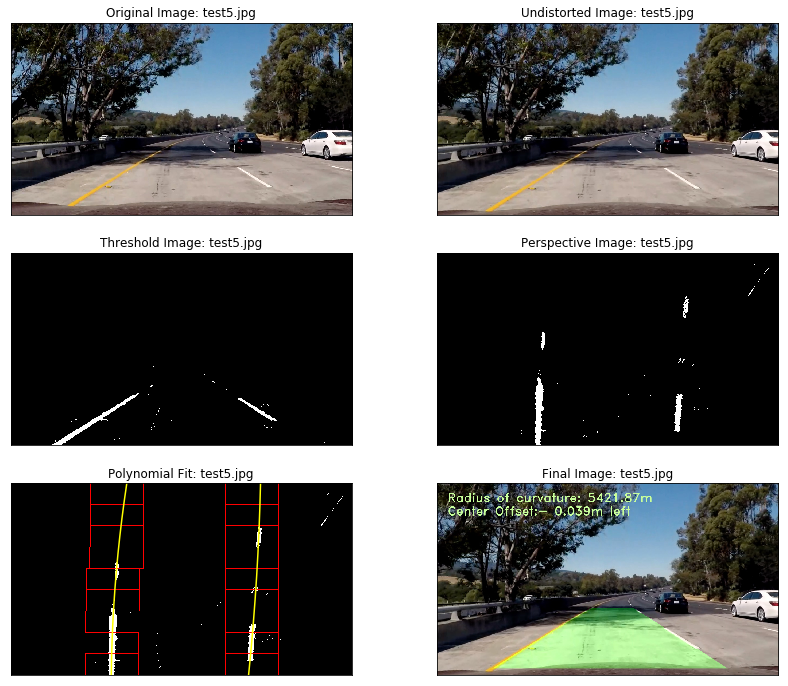

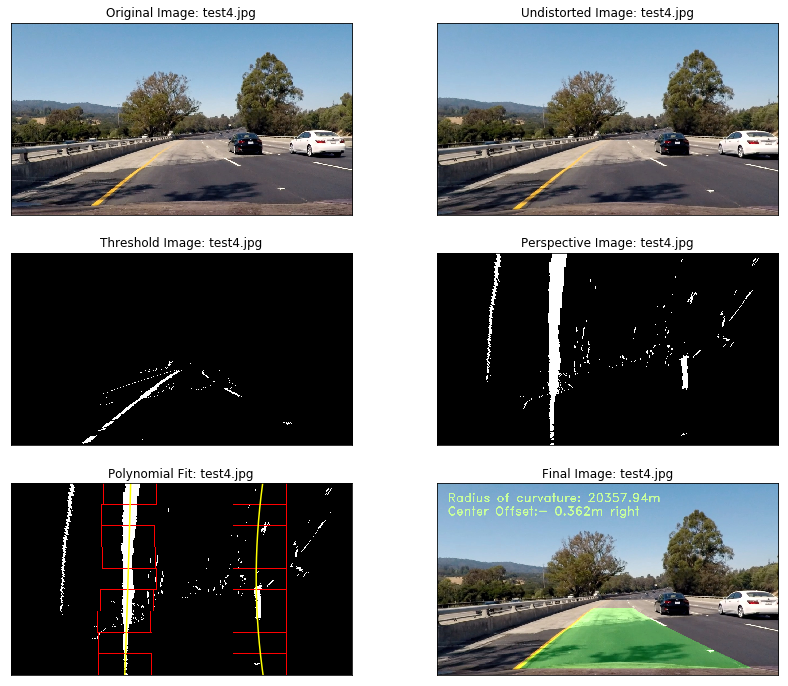

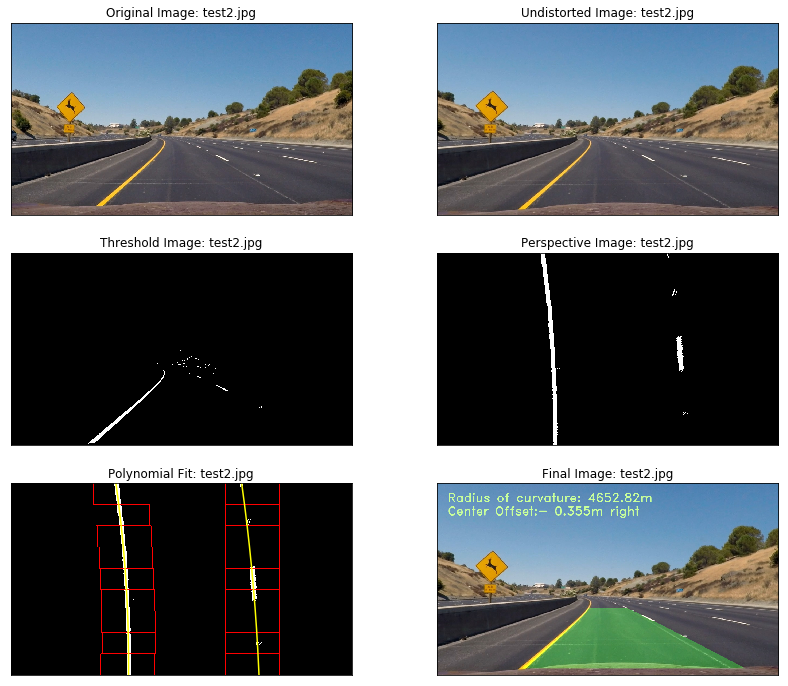

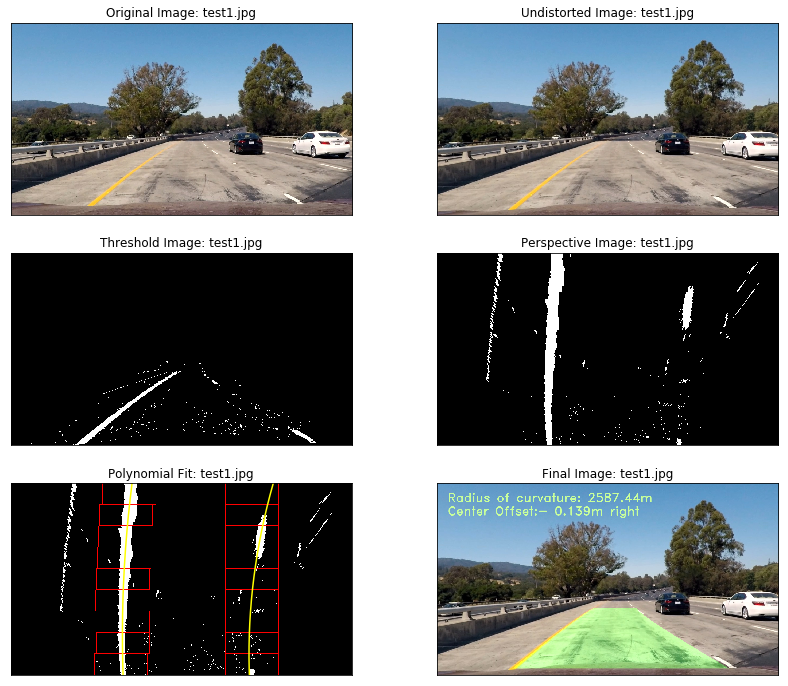

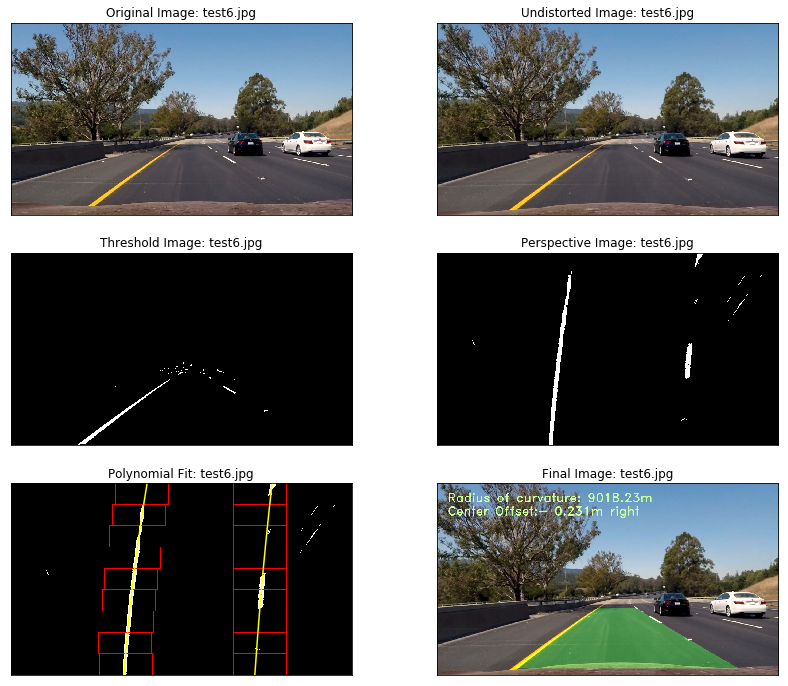

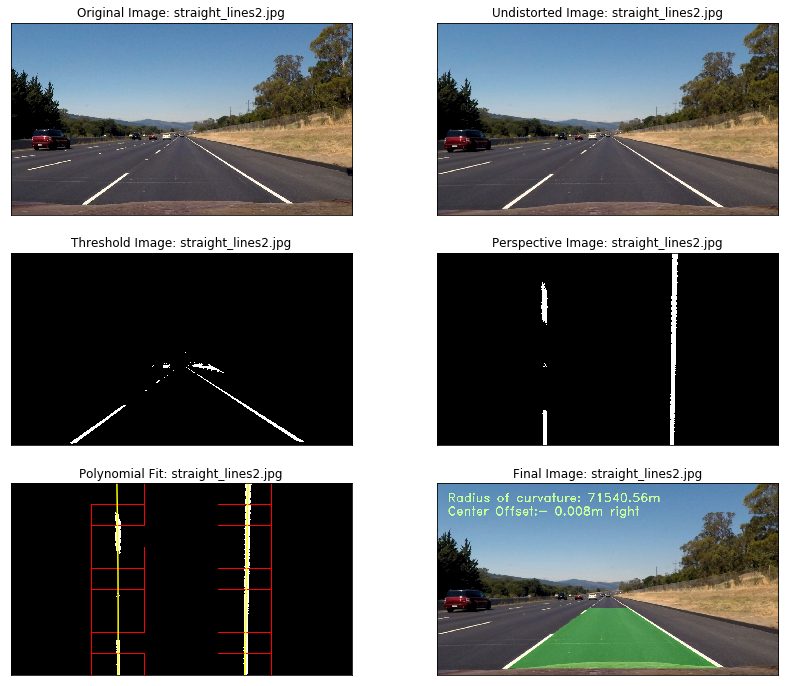

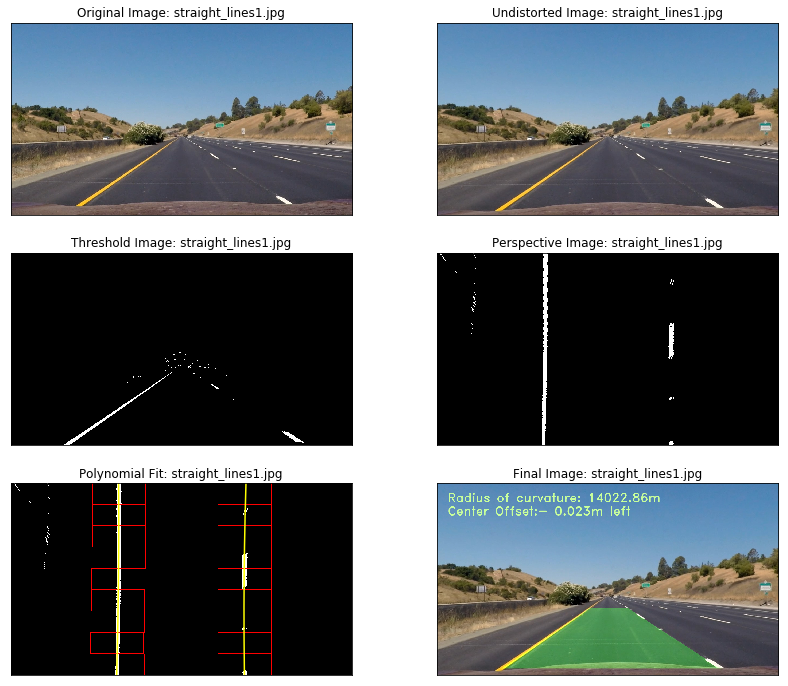

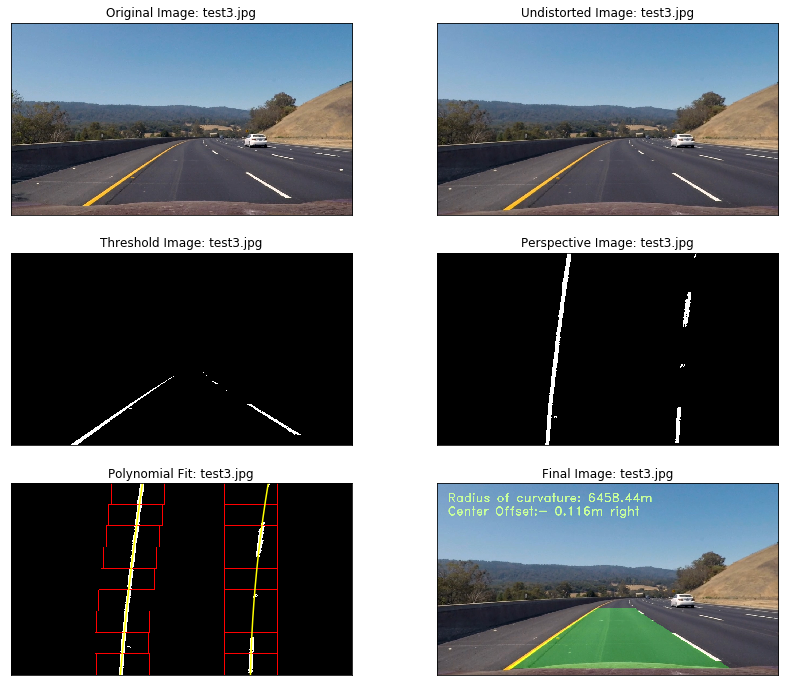

In [137]:
# Reading images from the test directory
def read_image(img):
    testImageDir = 'test_images'
    return plt.imread(testImageDir + '/' + img)
dist_ouput_dir = 'output_images/distortion_corrected'

thresh_ouput_dir = 'output_images/binary_image'

perspective_ouput_dir = 'output_images/perspective_transformed'

polynomial_ouput_dir = 'output_images/polynomial_fit' 

final_ouput_dir = 'output_images/final_image' 

for image_file in image_files:
        image = read_image(image_file)
        
        #Preparing for subplots of different Processes
        plt.figure(figsize=(14,12))
        
        plt.subplot(321)
        plt.title("Original Image: "+ image_file)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(image)
        
        # Undistort test images
        undistort_img = undistort_frame(image)
        plt.subplot(322)
        plt.title("Undistorted Image: "+ image_file)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(undistort_img)
        if not os.path.exists(dist_ouput_dir):
            os.mkdir(dist_ouput_dir)
        cv2.imwrite(os.path.join(dist_ouput_dir , image_file), undistort_img)
        
        # Add threshold mask
        binary_image = combined_threshold(undistort_img)
        plt.subplot(323)
        plt.title("Threshold Image: "+ image_file)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(binary_image, cmap='gray')
        if not os.path.exists(thresh_ouput_dir):
            os.mkdir(thresh_ouput_dir)
        cv2.imwrite(os.path.join(thresh_ouput_dir , image_file), binary_image)
        
        # Apply perspective transform
        perspective_img, M, Minv = perspective_transform(binary_image)
        plt.subplot(324)
        plt.title("Perspective Image: "+ image_file)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(perspective_img, cmap='gray')
        if not os.path.exists(perspective_ouput_dir):
            os.mkdir(perspective_ouput_dir)
        cv2.imwrite(os.path.join(perspective_ouput_dir , image_file), perspective_img)
        
        # Calculate lane pixels
        leftx, lefty, rightx, righty, left_windows, right_windows = find_lane_pixels(perspective_img)
        left_fit, right_fit = find_lane(perspective_img)
        left_fitx, right_fitx, ploty = get_fit_lines(perspective_img, left_fit, right_fit)
        polynomial_image = np.dstack((perspective_img, perspective_img, perspective_img))*255
        for win in left_windows:
            cv2.rectangle(polynomial_image, win[0], win[1], (255, 0, 0), 2)
        for win in right_windows:
            cv2.rectangle(polynomial_image, win[0], win[1], (255, 0, 0), 2)
            
        plt.subplot(325)
        plt.title("Polynomial Fit: "+ image_file)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(polynomial_image)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, perspective_img.shape[1])
        plt.ylim(perspective_img.shape[0], 0)
        
        if not os.path.exists(polynomial_ouput_dir):
            os.mkdir(polynomial_ouput_dir)
        cv2.imwrite(os.path.join(polynomial_ouput_dir , image_file), polynomial_image)
        
        # Calculate lane pixels and draw lanes on the final image
        left_fit, right_fit = find_lane(perspective_img)
        leftx, rightx, ploty = get_fit_lines(perspective_img, left_fit, right_fit)
        final_img = draw_lane(undistort_img, perspective_img, left_fit, right_fit, Minv)
        mean_distance, center_offset = get_lane_values(leftx, rightx, ploty)
        radius = calculate_average_curvature(perspective_img, left_fit, right_fit)
        final_img = draw_text(final_img, radius, center_offset)
        
        plt.subplot(326)
        plt.title("Final Image: "+ image_file)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(final_img)
        
        if not os.path.exists(final_ouput_dir):
            os.mkdir(final_ouput_dir)
        cv2.imwrite(os.path.join(final_ouput_dir , image_file), final_img)
        
        plt.show()
        

In [121]:

#Now lets run pipeline on the frame of video
#Pipeline Steps
# - Distortion correction
# - Threshold mask
# - Perspective Transform
# - Line Detection
# Radius 
left_best_fit = None
right_best_fit = None

#Processing pipeline
def process_frame(img):
    undistorted = undistort_frame(img)
    masked = combined_threshold(undistorted)
    binary_warped, M, Minv = perspective_transform(masked)
    global left_best_fit
    global right_best_fit
    left_fit = None
    right_fit = None
    if left_best_fit == None or right_best_fit == None:
        left_fit, right_fit = find_lane(binary_warped)
    else:
        left_fit, right_fit = find_lane_fast(binary_warped, left_best_fit, right_best_fit)
        if left_fit is not None and right_fit is not None:
            if not lane_accuracy(binary_warped, left_fit, right_fit):
                left_fit, right_fit = find_lane(binary_warped)
    left_best_fit = left_fit
    right_best_fit = right_fit
    if left_best_fit is not None and right_best_fit is not None:
        leftx, rightx, ploty = get_fit_lines(binary_warped, left_best_fit, right_best_fit)
        mean_distance, center_offset = get_lane_values(leftx, rightx, ploty)
        radius = calculate_average_curvature(binary_warped, left_best_fit, right_best_fit)
        # 4.6) Draw the line
        result = draw_lane(img, binary_warped, left_best_fit, right_best_fit, Minv)
        # 4.7) Draw the text
        result = draw_text(result, radius, center_offset)
        # Return the processed frame
        return result
    else:
        return img

In [117]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [118]:
project_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_frame) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)


[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [07:34<00:00,  2.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 5min 5s, sys: 13.5 s, total: 5min 18s
Wall time: 7min 38s


In [122]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

<h1>Youtube Video Link https://youtu.be/hPvqmAD_XxM</h1>
    